## Importing Packages and Source Code

In [ ]:
import json
import os
import sys
## biom used to view Qiime Artifacts
import biom
%matplotlib inline 

In [ ]:
## Import Source Code
from src.data import make_dataset
from src.features import build_features, metrics_analysis
from src.models import make_models, evaluate_models
from src.visualizations import make_visualizations, dimensionality_analysis

In [ ]:
## Creating paths to store temp and out data
if not os.path.exists("data/temp"):
    os.makedirs("data/temp")
if not os.path.exists("data/out"):
    os.makedirs("data/out")

## Reading Data

In [ ]:
## Obtaining file paths
with open("config/data-params.json") as fh:
    file_paths = json.load(fh)

In [ ]:
# Reading Data
feature_table = make_dataset.read_feature_table(file_paths["feature_table_path"])
metadata = make_dataset.read_metadata(file_paths["metadata_path"])

In [ ]:
biom_table = make_dataset.feature_table_biom_view(feature_table)
print(biom_table.head())

In [ ]:
metadata.head()

# Create Features

In [ ]:
## Obtaining file paths
with open("config/feature-params.json") as fh:
    feature_params = json.load(fh)

In [ ]:
# Organizing metadata
organized_metadata = build_features.organize_metadata(metadata, biom_table.ids(), **feature_params)

In [ ]:
organized_metadata[0]

In [ ]:
organized_metadata[1]

# EDA

In [ ]:
make_visualizations.create_bar_col_binary(organized_metadata[1], 'ckd_v2')

In [ ]:
diseases_cols = {
    'abdominal_obesity_ncep_v2': 'Obesity',
    'ckd_v2': 'Chronic Kidney Disease',
    'diabetes2_v2': 'Diabetes',
    'precvd_v2': 'Pre-CVD',
    'elevated_bp_selfmeds_v2': 'Elevated Blood Pressure',
    'dyslipidemia_v2': 'Dyslipidemia'
}

In [ ]:
organized_metadata[0]

In [ ]:
make_visualizations.disease_counts_graph(organized_metadata[0].rename(columns=diseases_cols), disease_cols=diseases_cols.values())

In [ ]:
organized_metadata[0][feature_params['disease_cols']].sum(axis=1).value_counts().sort_values(ascending=False)

In [ ]:
make_visualizations.total_disease_count_graph(organized_metadata[0],feature_params['disease_cols'])

# Model Building

In [ ]:
## Obtaining model params
with open("config/model-params.json") as fh:
    model_params = json.load(fh)

In [ ]:
precvd_undersample = organized_metadata[1][['precvd_v2']]
precvd_undersample

In [ ]:
# Balancing precvd classes
balanced_precvd_df = build_features.balance_precvd(organized_metadata[1])

In [ ]:
qiime_metadata_tf = make_dataset.read_qiime_metadata("data/temp/final_metadata_tf.tsv")
qiime_metadata_tf

In [ ]:
filtered_table = make_dataset.filter_feature_table(feature_table, 4, qiime_metadata_tf)
filtered_table.view(biom.Table)

In [ ]:
binary_relevance_model = make_models.binary_relevance_model(filtered_table, qiime_metadata_tf,balanced_precvd_df, model_params['disease_targets'])

# Model Peformance

In [ ]:
disease_accuracy_scores = evaluate_models.binary_relevance_accuracy_scores(binary_relevance_model, feature_params['disease_cols'])
disease_accuracy_scores

In [ ]:
make_visualizations.binary_relevance_accuracy_scores_graph(disease_accuracy_scores)

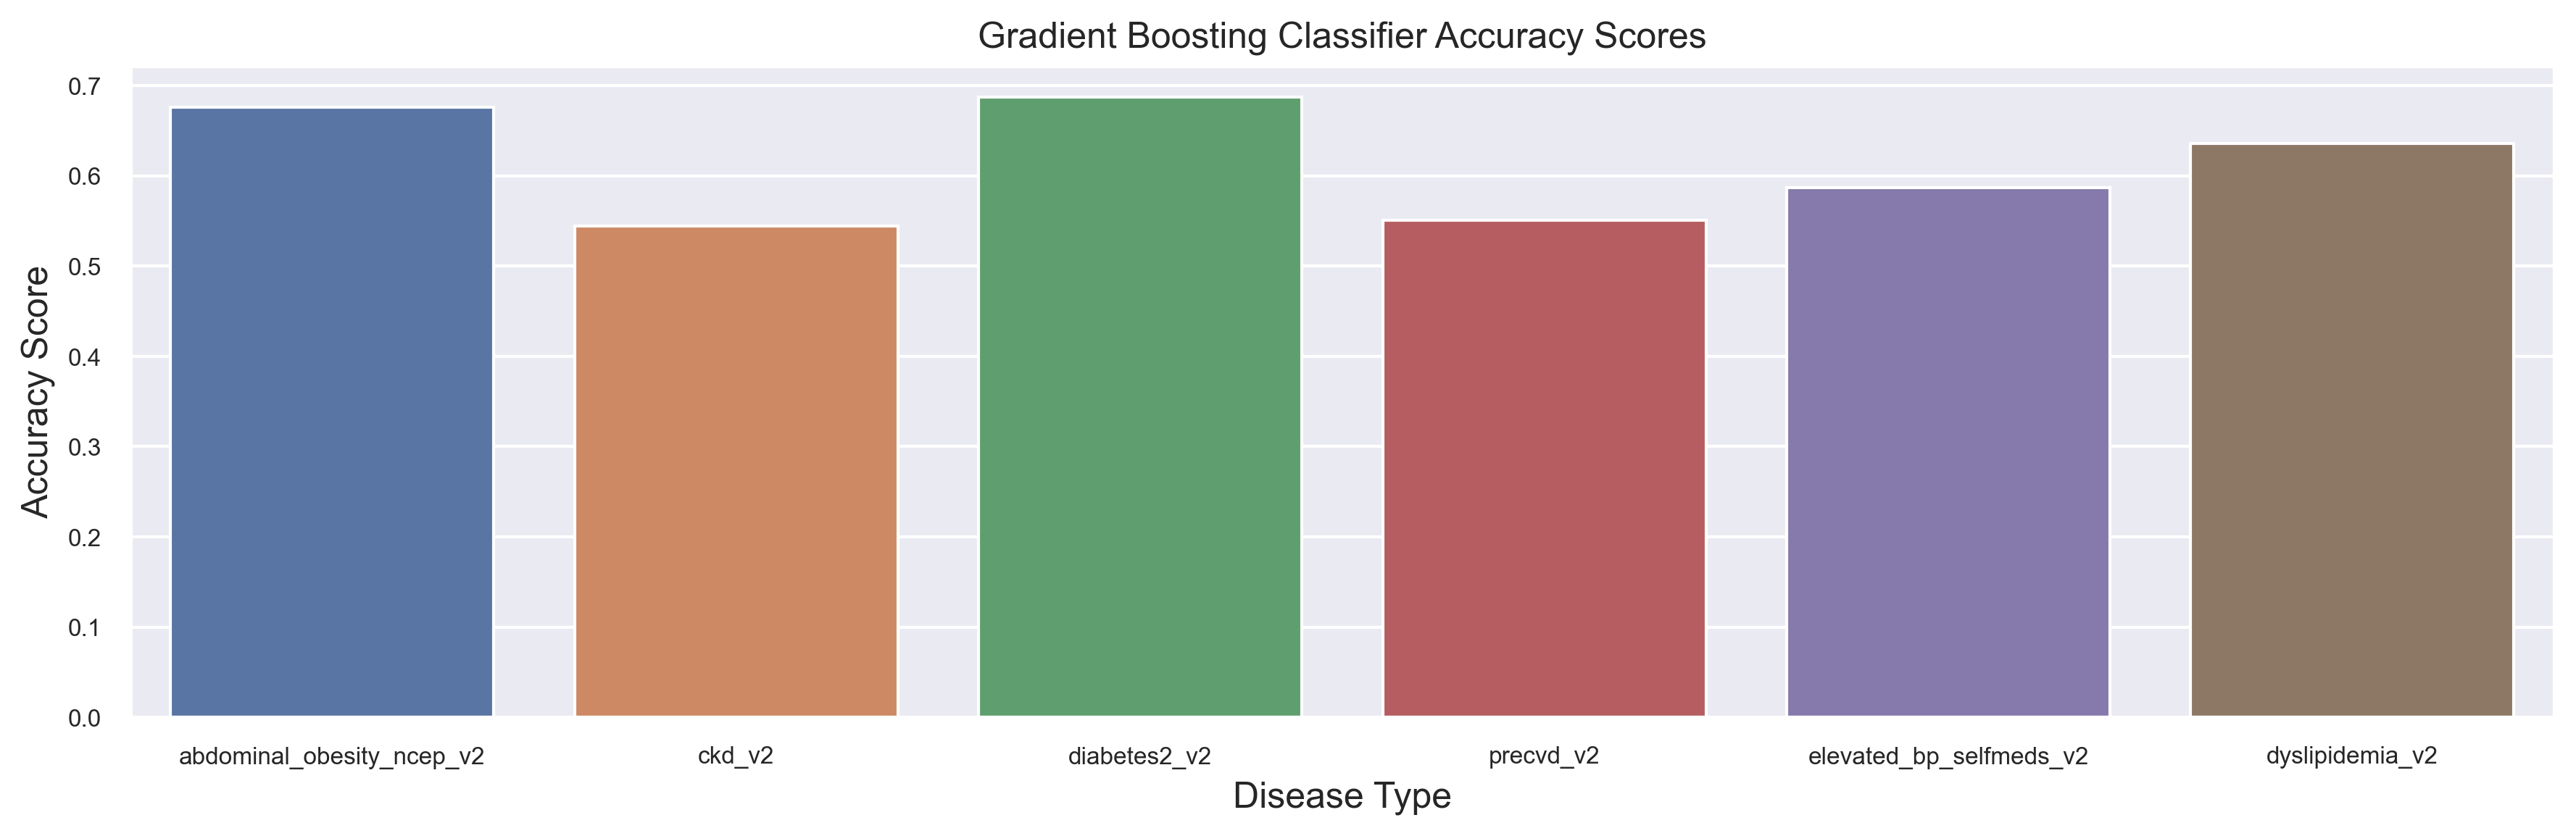

The auc's below were collected from qiime2.view by uploading the '.qzv' files found in data/out after running the model (make_models.binary_relevance_model)

In [ ]:
aucs = {'abdominal_obesity_ncep_v2':[0.70,0.52],'ckd_v2':[0.57,0.56],
'diabetes2_v2':[0.73,0.61],'precvd_v2':[0.55,0.56],
'elevated_bp_selfmeds_v2':[0.63,0.61],'dyslipidemia_v2':[0.67,0.55]} # micro, macro

As we can see by the results, the average overall accuracy of the models was about 60.9% and all the AUC’s are above 50% which means that every model performed better than random chance.

In [ ]:
make_visualizations.binary_relevance_accuracy_scores_graph_with_auc(disease_accuracy_scores,aucs)

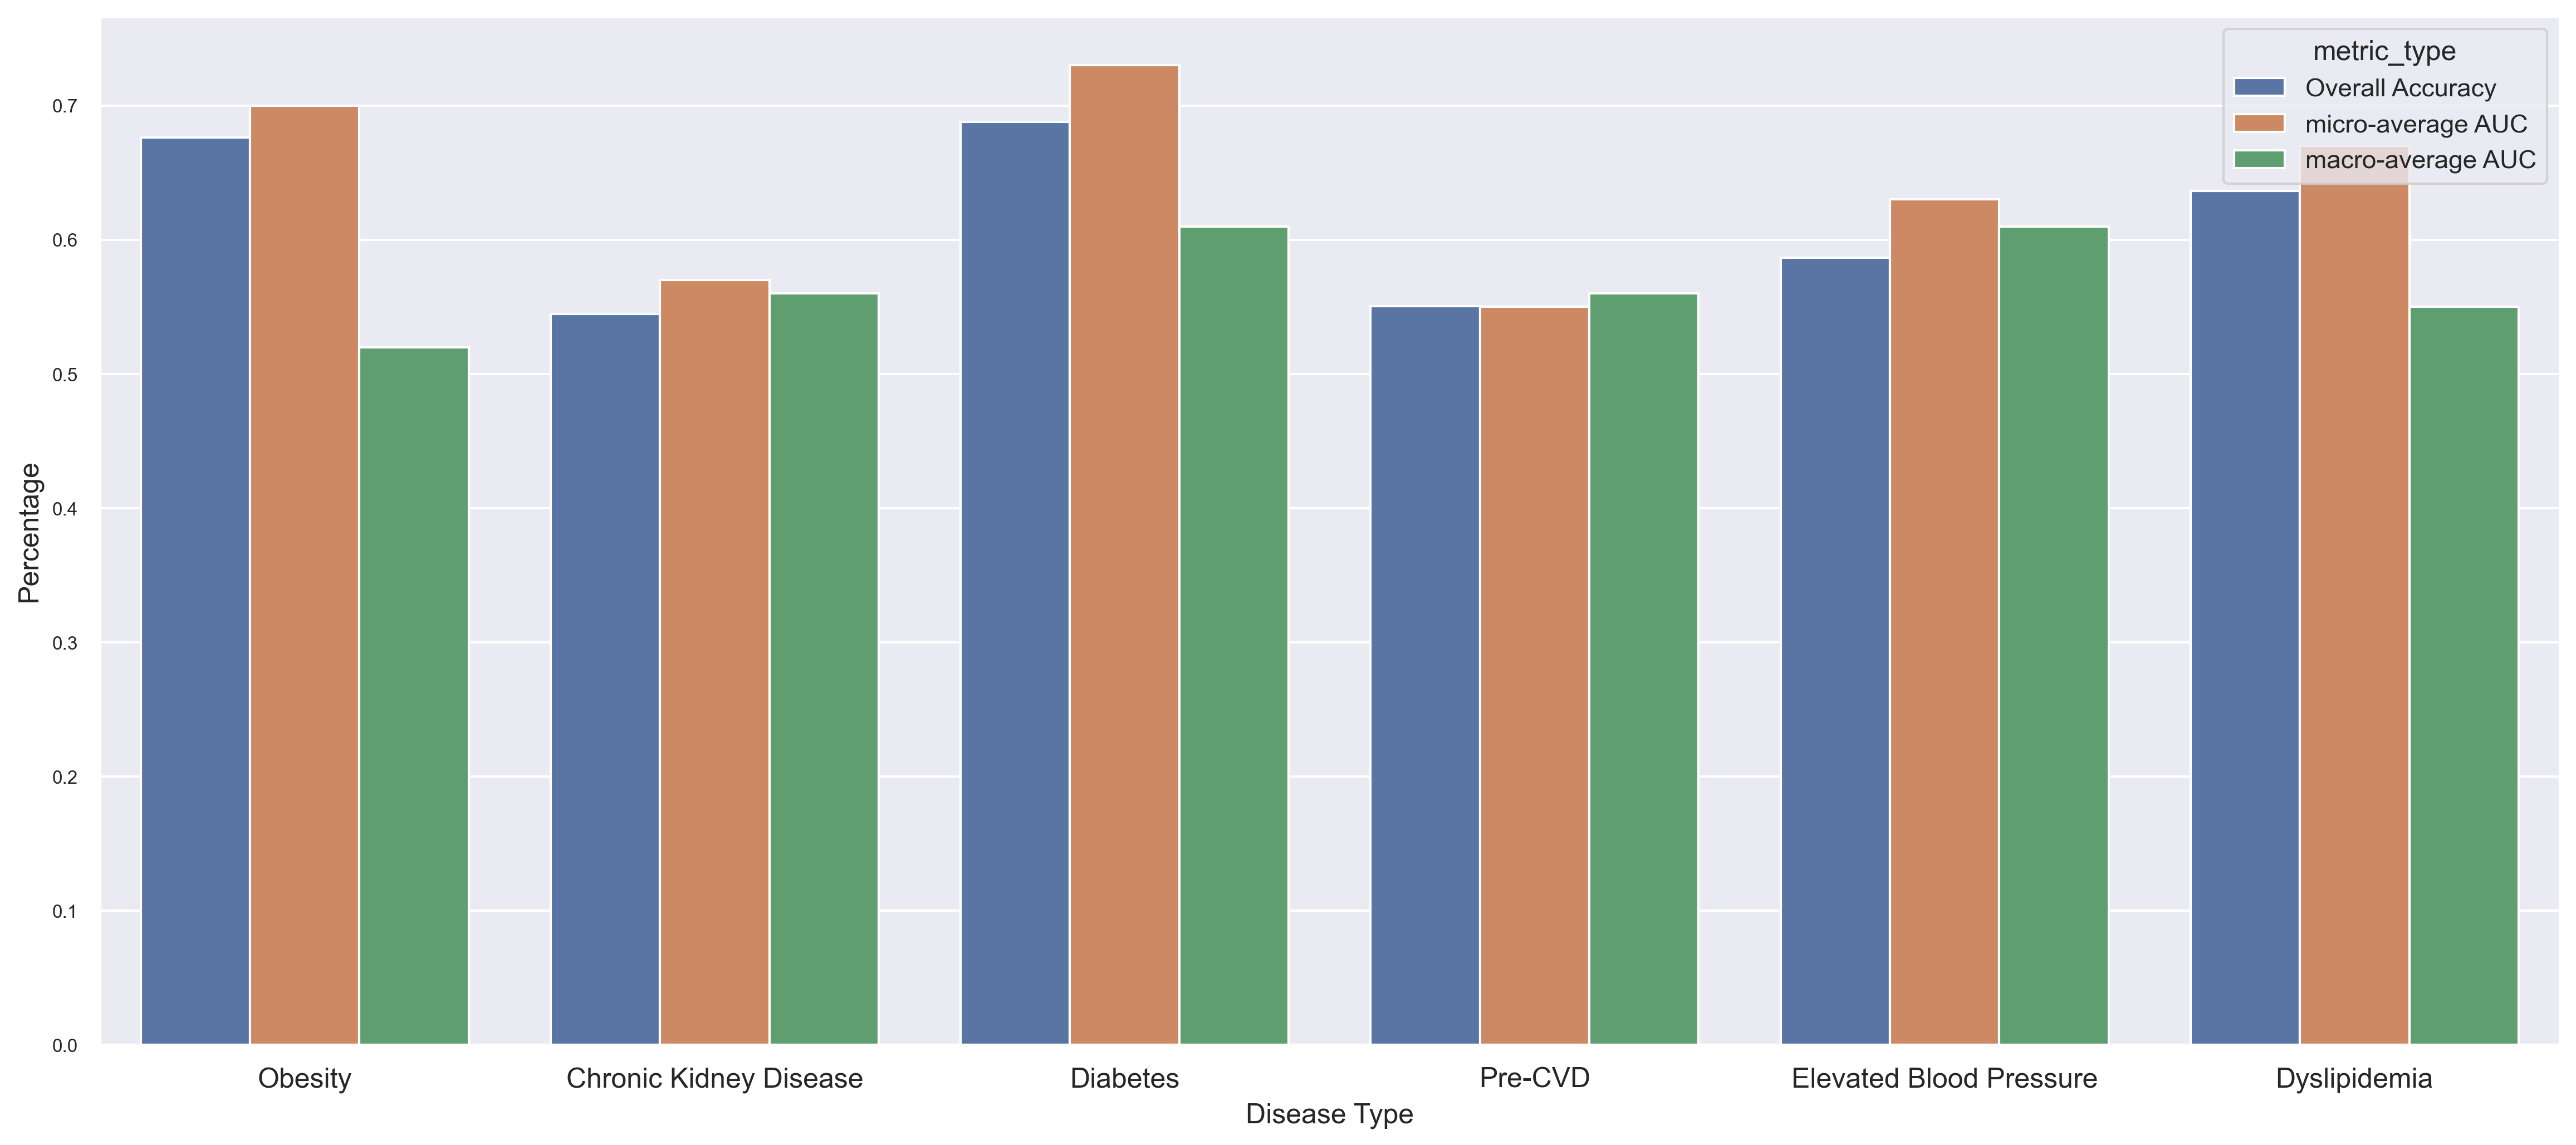